In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

from env_two_step import Scenario
from util import mat2str, dictsum, moving_average

# DQN imports 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
# initialize args
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

args = namedtuple('args', ('render', 'gamma', 'log_interval'))
args.render= True
args.gamma = 0.99
args.log_interval = 10

In [3]:
class AMoD:
    # initialization
    def __init__(self, scenario, beta=0.2): # updated to take scenario and beta (cost for rebalancing) as input
        self.scenario = deepcopy(scenario) # I changed it to deep copy so that the scenario input is not modified by env 
        self.G = scenario.G # Road Graph: node - region, edge - connection of regions, node attr: 'accInit', edge attr: 'time'
        self.time = 0 # current time
        self.T = scenario.T # planning time
        self.tf = scenario.tf # final time
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        for i,j,t,d,p in scenario.tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
        self.acc = defaultdict(dict) # number of vehicles within each region, key: i - region, t - time
        self.dacc = defaultdict(dict) # number of vehicles arriving at each region, key: i - region, t - time
        self.rebFlow = defaultdict(dict) # number of rebalancing vehicles, key: (i,j) - (origin, destination), t - time
        self.paxFlow = defaultdict(dict) # number of vehicles with passengers, key: (i,j) - (origin, destination), t - time
        self.edges = [] # set of rebalancing edges
        self.nregion = len(scenario.G) # number of regions
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
                self.region = list(self.G) # set of regions
        self.nedge = [len(self.G.out_edges(n))+1 for n in self.region] # number of edges leaving each region        
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.region:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float)   
        self.beta = beta
        t = self.time
        self.servedDemand = defaultdict(float)
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
        
        self.N = len(self.region) # total number of cells
        
        # add the initialization of info here
        self.info = dict.fromkeys(['revenue', 'served_demand', 'rebalancing_cost', 'operating_cost'], 0)
        self.reward = 0
        # observation: current vehicle distribution, time, future arrivals, demand        
        self.obs = (self.acc, self.time, self.dacc, self.demand)

    def matching(self, CPLEXPATH=None, PATH=''):
        t = self.time
        demandAttr = [(i,j,self.demand[i,j][t], self.price[i,j][t]) for i,j in self.demand \
                      if self.demand[i,j][t]>1e-3]
        accTuple = [(n,self.acc[n][t+1]) for n in self.acc]
        modPath = os.getcwd().replace('\\','/')+'/mod/'
        matchingPath = os.getcwd().replace('\\','/')+'/matching/'+PATH
        if not os.path.exists(matchingPath):
            os.makedirs(matchingPath)
        datafile = matchingPath + 'data_{}.dat'.format(t)
        resfile = matchingPath + 'res_{}.dat'.format(t)
        with open(datafile,'w') as file:
            file.write('path="'+resfile+'";\r\n')
            file.write('demandAttr='+mat2str(demandAttr)+';\r\n')
            file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
        modfile = modPath+'matching.mod'
        if CPLEXPATH is None:
            CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
        my_env = os.environ.copy()
        my_env["LD_LIBRARY_PATH"] = CPLEXPATH
        out_file =  matchingPath + 'out_{}.dat'.format(t)
        with open(out_file,'w') as output_f:
            subprocess.check_call([CPLEXPATH+"oplrun", modfile,datafile],stdout=output_f,env=my_env)
        output_f.close()
        flow = defaultdict(float)
        with open(resfile,'r', encoding="utf8") as file:
            for row in file:
                item = row.replace('e)',')').strip().strip(';').split('=')
                if item[0] == 'flow':
                    values = item[1].strip(')]').strip('[(').split(')(')
                    for v in values:
                        if len(v) == 0:
                            continue
                        i,j,f = v.split(',')
                        flow[int(i),int(j)] = float(f)
        paxAction = [flow[i,j] if (i,j) in flow else 0 for i,j in self.edges]
        return paxAction

    # pax step
    def pax_step(self, paxAction=None, CPLEXPATH=None, PATH=''):
        t = self.time
        self.reward = 0
        for i in self.region:
            self.acc[i][t+1] = self.acc[i][t]
        self.info['served_demand'] = 0 # initialize served demand
        self.info["operating_cost"] = 0 # initialize operating cost
        self.info['revenue'] = 0
        self.info['rebalancing_cost'] = 0
        if paxAction is None:  # default matching algorithm used if isMatching is True, matching method will need the information of self.acc[t+1], therefore this part cannot be put forward
            paxAction = self.matching(CPLEXPATH=CPLEXPATH, PATH=PATH)
        self.paxAction = paxAction
        # serving passengers
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # I moved the min operator above, since we want paxFlow to be consistent with paxAction
            self.paxAction[k] = min(self.acc[i][t+1], paxAction[k])            
            self.servedDemand[i,j][t] = self.paxAction[k]
            self.paxFlow[i,j][t+self.G.edges[i,j]['time']] = self.paxAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.paxAction[k]
            self.acc[i][t+1] -= self.paxAction[k]
            self.info['served_demand'] += self.servedDemand[i,j][t]            
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.paxFlow[i,j][t+self.G.edges[i,j]['time']]
            self.reward += self.paxAction[k]*(self.price[i,j][t] - self.G.edges[i,j]['time']*self.beta)            
            self.info['revenue'] += self.paxAction[k]*self.price[i,j][t]  
        
        self.obs = (self.acc, self.time, self.dacc, self.demand) # for acc, the time index would be t+1, but for demand, the time index would be t
        done = False # if passenger matching is executed first
        return self.obs, max(0,self.reward), done, self.info
    
    # reb step
    def reb_step(self, rebAction):
        t = self.time
        self.rebAction = rebAction      
        # rebalancing
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # TODO: add check for actions respecting constraints? e.g. sum of all action[k] starting in "i" <= self.acc[i][t+1] (in addition to our agent action method)
            # update the number of vehicles
            self.rebAction[k] = min(self.acc[i][t+1], rebAction[k]) 
            self.rebFlow[i,j][t+self.G.edges[i,j]['time']] = self.rebAction[k]     
            self.acc[i][t+1] -= self.rebAction[k] 
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.rebFlow[i,j][t+self.G.edges[i,j]['time']]   
            self.info['rebalancing_cost'] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.reward -= self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
        # arrival for the next time step, executed in the last state of a time step
        # this makes the code slightly different from the previous version, where the following codes are executed between matching and rebalancing        
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            self.acc[j][t+1] += self.rebFlow[i,j][t]
            self.acc[j][t+1] += self.paxFlow[i,j][t] # this means that after pax arrived, vehicles can only be rebalanced in the next time step, let me know if you have different opinion
            
        self.time += 1
        self.obs = (self.acc, self.time, self.dacc, self.demand) # use self.time to index the next time step
        
        done = (self.tf == t+1) # if the episode is completed
        return self.obs, self.reward, done, self.info
    
    def reset(self):
        # reset the episode
        self.acc = defaultdict(dict)
        self.dacc = defaultdict(dict)
        self.rebFlow = defaultdict(dict)
        self.paxFlow = defaultdict(dict)
        self.edges = []
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
        
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        tripAttr = self.scenario.get_random_demand(reset=True)
        for i,j,t,d,p in tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
            
        self.time = 0
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.G:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float) 
        t = self.time
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
         # TODO: define states here
        self.obs = (self.acc, self.time, self.dacc, self.demand)      
        self.reward = 0
        return self.obs

class Scenario:
    def __init__(self, N1=2, N2=4, tf=60, T=10, sd=None, ninit=5, tripAttr=None, demand_input=None,
                 trip_length_preference = 0.25, grid_travel_time = 1):
        # trip_length_preference: positive - more shorter trips, negative - more longer trips
        # grid_travel_time: travel time between grids
        # demand_input： list - total demand out of each region, 
        #          float/int - total demand out of each region satisfies uniform distribution on [0, demand_input]
        #          dict/defaultdict - total demand between pairs of regions
        # demand_input will be converted to a variable static_demand to represent the demand between each pair of nodes
        # static_demand will then be sampled according to a Poisson distribution
        self.trip_length_preference = trip_length_preference
        self.grid_travel_time = grid_travel_time
        self.demand_input = demand_input
        self.N1 = N1
        self.N2 = N2
        self.G = nx.complete_graph(N1*N2)
        self.G = self.G.to_directed()
        for i,j in self.G.edges:
            self.G.edges[i,j]['time'] = (abs(i//N1-j//N1) + abs(i%N1-j%N1))*grid_travel_time
        for n in self.G.nodes:
            self.G.nodes[n]['accInit'] = ninit
        self.tf = tf
        self.sd = sd
        if sd != None:
            np.random.seed(self.sd)
        self.T = T
        if tripAttr != None: # given demand as a defaultdict(dict)
            self.tripAttr = deepcopy(tripAttr)
        else:
            self.tripAttr = self.get_random_demand() # randomly generated demand
    
    def get_random_demand(self, reset = False):        
        # generate demand and price
        # reset = True means that the function is called in the reset() method of AMoD enviroment,
        #   assuming static demand is already generated
        # reset = False means that the function is called when initializing the demand
        
        demand = defaultdict(dict)
        price = defaultdict(dict)        
        tripAttr = []
        
        # default demand
        if self.demand_input == None:
            # generate demand, travel time, and price
            D = dict()
            for i,j in self.G.edges:
                D[i,j] = np.random.rand() * 0.5
                for t in range(0,self.tf+self.T):
                    if t%2 == 0:
                        if (i==0) and (j==7):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==6) and (j==1):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    else:
                        if (i==7) and (j==0):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==1) and (j==6):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    price[i,j][t] = 3*self.G.edges[i,j]['time']
            tripAttr = []
            for i,j in demand:
                for t in demand[i,j]:
                    tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))
            return tripAttr
        
        # converting demand_input to static_demand
        # skip this when resetting the demand
        if not reset:
            self.static_demand = dict()
            if type(self.demand_input) in [float, int, list, np.array]:
                if type(self.demand_input) in [float, int]:            
                    self.region_demand = np.random.rand(len(self.G)) * self.demand_input  
                else:
                    self.region_demand = self.demand_input            
                for i in self.G.nodes:
                    J = [j for _,j in self.G.out_edges(i)]
                    prob = np.array([np.math.exp(-self.G.edges[i,j]['time']*self.trip_length_preference) for j in J])
                    prob = prob/sum(prob)
                    for idx in range(len(J)):
                        self.static_demand[i,J[idx]] = self.region_demand[i] * prob[idx]
            elif type(self.demand_input) in [dict, defaultdict]:
                for i,j in self.G.edges:
                    self.static_demand[i,j] = self.demand_input[i,j] if (i,j) in self.demand_input else self.demand_input['default']
            else:
                raise Exception("demand_input should be number, array-like, or dictionary-like values")
        
        # generating demand and prices
        for t in range(0,self.tf+self.T):
            for i,j in self.G.edges:
                demand[i,j][t] = np.random.poisson(self.static_demand[i,j])
#                 price[i,j][t] = 3 * self.G.edges[i,j]['time']
                price[i,j][t] = min(3,np.random.exponential(2)+1) * self.G.edges[i,j]['time']
                tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))
        
        return tripAttr

In [8]:
class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.L = 3 # number of levels
        self.Ms = 5 # state-space discretization
        self.Ma = 5 # action-space discretization
        self.K = 2 # number of time-intervals
        self.nA = self.Ma # number of actions
        self.nS = self.K * (self.Ms + 1) # number of states (+1 represents extra state'lambda')
        self.region = env.region # list of cells
        self.n_vehicles = env.G.nodes[0]['accInit']*len(env.region) # total number of vehicles
        self.cascaded_regions = self._get_cascaded_regions() # regions for each level of cascade, key: l - 'level', r: - 'region'
        # initialize state/action spaces
        # state_space: list with elements (k, vleft, vright) -> observed distribution of AVs (at time k)
        # action_space: list with elements (vleft, vright) -> desired distribution of AVs 
        self.state_space, self.action_space = self._get_state_action_space()
        
        self.affine1 = nn.Linear(1209, 32)
        self.affine2 = nn.Linear(32, 32)
        self.affine3 = nn.Linear(32, 32)
        self.affine4 = nn.Linear(32, 32)
        self.affine5 = nn.Linear(32, 32)

        # actor's layer
        self.action_head = nn.Linear(32, 8)

        # critic's layer
        self.value_head = nn.Linear(32, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        x = F.relu(self.affine3(x))
        x = F.relu(self.affine4(x))
        x = F.relu(self.affine5(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(x)).reshape(-1) + 1e-20

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values
    
    def _get_state_action_space(self):
        vs_state = np.linspace(0, 1, self.Ms) # enumerate all possible v_i values 
        vs_action = np.linspace(0, 1, self.Ma) # enumerate all possible x_i^d values
        state_space, action_space = [], []
        for vleft in vs_state:
            for k in range(self.K):
                state_space.append((k, vleft, 1-vleft))
            action_space.append((vleft, 1-vleft))
        state_space.append('lambda')
        return state_space, action_space
    
    def _get_cascaded_regions(self):
        cascaded_regions = dict()
        for l in range(1, self.L+1):
            n_l = 2**(l) # number of nodes in level 'l'
            splits = np.array_split(self.region, n_l)
            for node, split in enumerate(splits):
                cascaded_regions[l-1, node+1] = split
        return cascaded_regions
    
    def decode_state(self, raw_s, t):
        """
        Decodes raw environment state into state representation for learning.
        
        Parameters
        ----------
        raw_s : array_like
                Availability of idle vehicles as in env.acc.
        t : int
            Current environemt time.
        Returns
        -------
        s : array_like
            Idle vehicle distribution for every node.
        """
        k = t%self.K
        s = []
        list_regions = list(self.cascaded_regions.keys())
        for i in range(0, len(list_regions)-1, 2):
            x_left, x_right = 0, 0
            for cell in self.cascaded_regions[list_regions[i]]:
                x_left += raw_s[cell][t]
            for cell in self.cascaded_regions[list_regions[i+1]]:
                x_right += raw_s[cell][t]
            if x_left==x_right==0.:
                s.append("lambda")
            else:
                v_left = min(np.linspace(0, 1, self.Ms), key=lambda x:abs(x - (x_left / (x_left + x_right))))
                v_right = 1 - v_left
                s.append((k, v_left, v_right))
        return s
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([env.acc[region][env.time] for region in env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())

def select_action(state):
    state = state
    concentrations, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Dirichlet(concentrations)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (distribution of idle vehicles over cells)
    return list(action.numpy())

def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + args.gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),5.)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [9]:
scenario = Scenario(sd=10, demand_input = {(1,6):2, (0,7):2, 'default':0.1})

In [10]:
env = AMoD(scenario)

In [11]:
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

In [12]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 10*500 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, reward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v7/")
#             episode_reward += reward
            reward = torch.tensor([reward], device=device).float()
            # Select and perform an RL action
            state = torch.tensor([obs[0][n][env.time] for n in model.region] + [env.dacc[n][t] for n in model.region for t in range(env.time, env.time+10)] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + [env.time]).float()
            action_rl = select_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v7/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, reward, done, info = env.reb_step(rebAction)
            reward = torch.tensor([reward], device=device).float()
            new_state = torch.tensor([new_obs[0][n][env.time] for n in model.region] + [env.dacc[n][t] for n in model.region for t in range(env.time, env.time+10)] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + [env.time]).float()

            # Store the transition in memory
            model.rewards.append(reward.item())

            # Move to the next state
            # track performance over episode
            episode_reward += reward.item()
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            if done:
                break
        
        # perform backprop
        finish_episode()
        
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 3429 | Reward: 2062.85 | Revenue: 2380.65 | ServedDemand: 345.00 | Reb. Cost: 107.60 | Oper. Cost: 317.80:  69%|██████▊   | 3429/5000 [5:04:23<3:24:56,  7.83s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



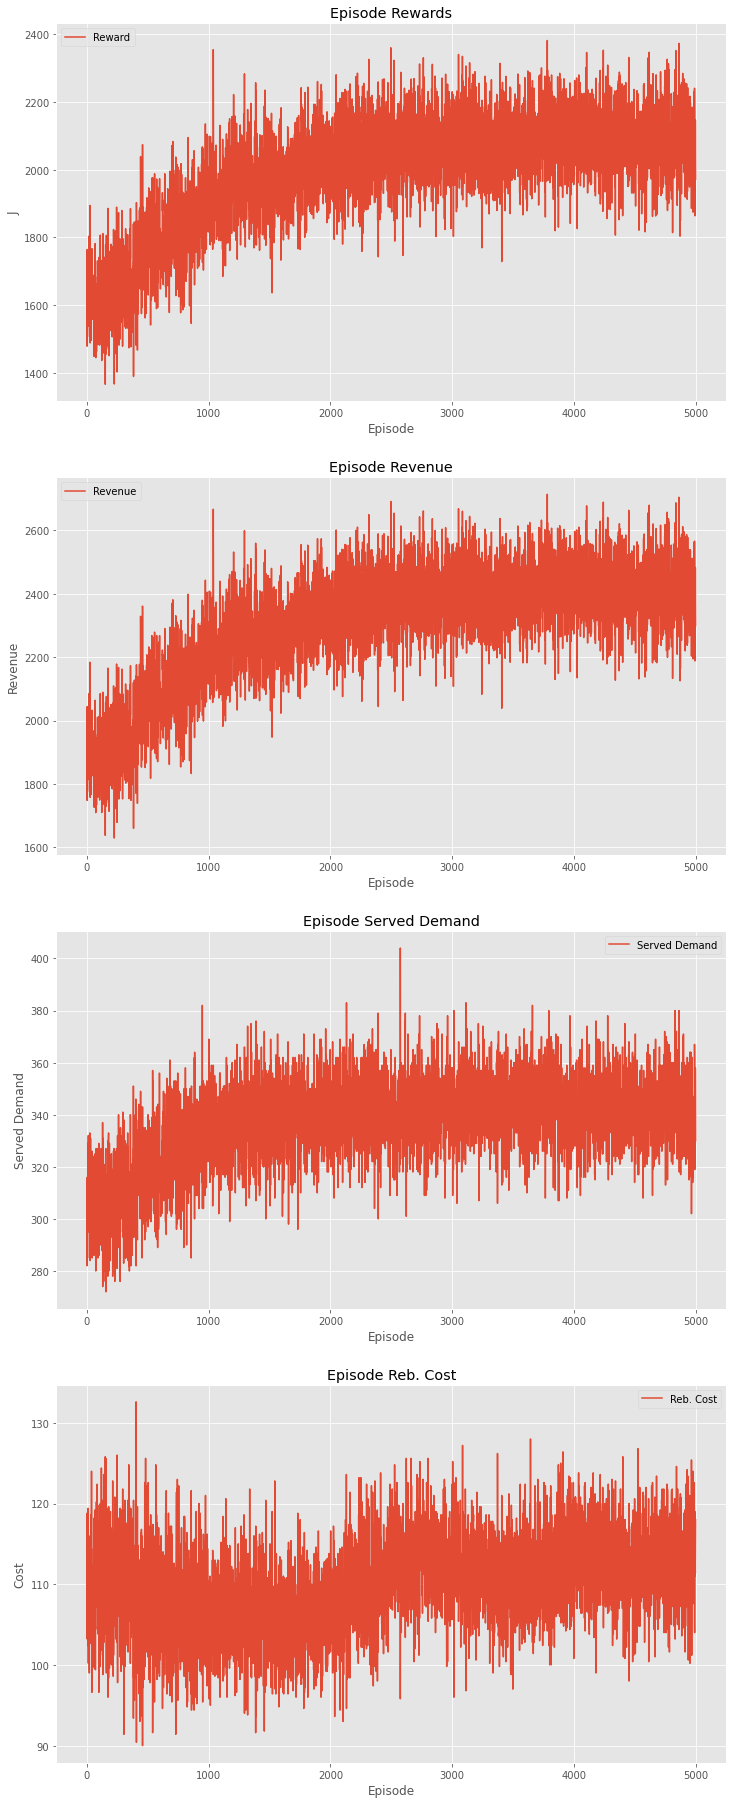

Average Performance: 

Avg Reward: 1991.37
Total Revenue: 2302.81
Total Served Demand: 336.82
Total Rebalancing Cost: 109.98


In [15]:
# Plot results
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(training_rewards, label="Reward")
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(training_revenue, label="Revenue")
plt.title("Episode Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(training_served_demand, label="Served Demand")
plt.title("Episode Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(training_rebalancing_cost, label="Reb. Cost")
plt.title("Episode Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

print("Average Performance: \n")
print(f'Avg Reward: {np.mean(training_rewards):.2f}')
print(f'Total Revenue: {np.mean(training_revenue):.2f}')
print(f'Total Served Demand: {np.mean(training_served_demand):.2f}')
print(f'Total Rebalancing Cost: {np.mean(training_rebalancing_cost):.2f}')

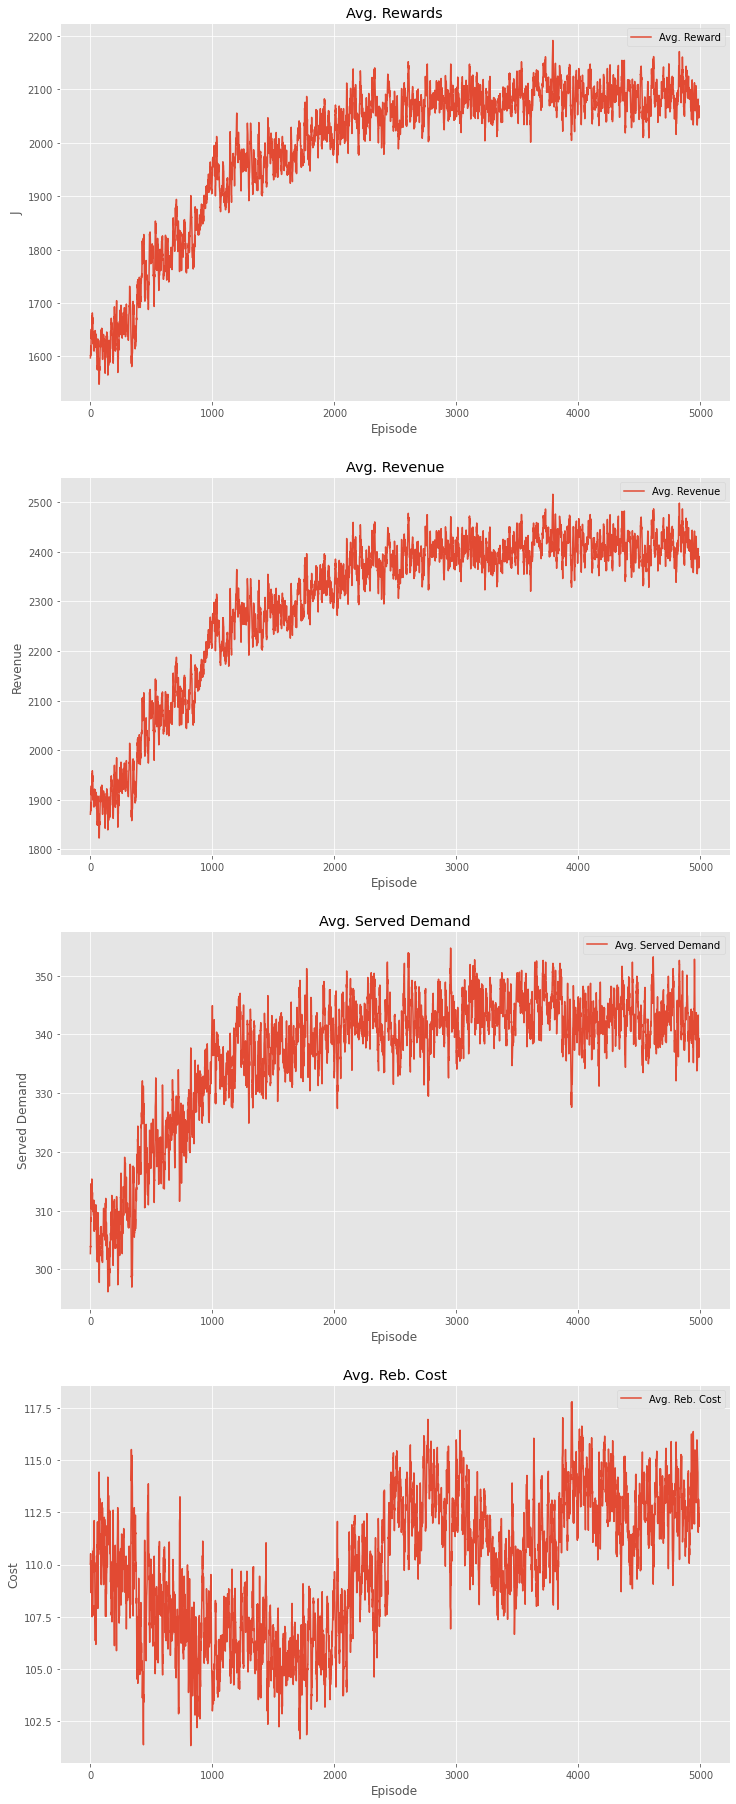

In [16]:
# Plot results with moving average smoothing 
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

#### Test

In [18]:
# Test Episodes
test_episodes = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

# book-keeping variables
test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []

for episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, reward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v7Test/")
#             episode_reward += reward
            reward = torch.tensor([reward], device=device).float()
            # Select and perform an RL action
            state = torch.tensor([obs[0][n][env.time] for n in model.region] + [env.dacc[n][t] for n in model.region for t in range(env.time, env.time+10)] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + [env.time]).float()
            action_rl = select_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v7Test/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, reward, done, info = env.reb_step(rebAction)
            reward = torch.tensor([reward], device=device).float()
            new_state = torch.tensor([new_obs[0][n][env.time] for n in model.region] + [env.dacc[n][t] for n in model.region for t in range(env.time, env.time+10)] + \
                                 [env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + \
                                [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand] + [env.time]).float()

            # Store the transition in memory
            model.rewards.append(reward.item())

            # Move to the next state
            # track performance over episode
            episode_reward += reward.item()
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)

            # end episode if conditions reached
            if done:
                break
            
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break


  0%|          | 0/100 [00:00<?, ?it/s]
Episode 1 | Reward: 2027.31 | Revenue: 2346.31 | ServedDemand: 353.00 | Oper. Cost: 319.00:   0%|          | 0/100 [00:28<?, ?it/s]
Episode 1 | Reward: 2027.31 | Revenue: 2346.31 | ServedDemand: 353.00 | Oper. Cost: 319.00:   1%|          | 1/100 [00:28<46:35, 28.24s/it]
Episode 2 | Reward: 2051.88 | Revenue: 2380.08 | ServedDemand: 331.00 | Oper. Cost: 328.20:   1%|          | 1/100 [00:44<46:35, 28.24s/it]
Episode 2 | Reward: 2051.88 | Revenue: 2380.08 | ServedDemand: 331.00 | Oper. Cost: 328.20:   2%|▏         | 2/100 [00:44<40:23, 24.73s/it]
Episode 3 | Reward: 2082.54 | Revenue: 2401.74 | ServedDemand: 351.00 | Oper. Cost: 319.20:   2%|▏         | 2/100 [01:02<40:23, 24.73s/it]
Episode 3 | Reward: 2082.54 | Revenue: 2401.74 | ServedDemand: 351.00 | Oper. Cost: 319.20:   3%|▎         | 3/100 [01:02<36:37, 22.65s/it]
Episode 4 | Reward: 2154.45 | Revenue: 2476.05 | ServedDemand: 351.00 | Oper. Cost: 321.60:   3%|▎         | 3/100 [01:26<36:37

Episode 29 | Reward: 1996.40 | Revenue: 2311.60 | ServedDemand: 327.00 | Oper. Cost: 315.20:  28%|██▊       | 28/100 [10:59<24:27, 20.38s/it]
Episode 29 | Reward: 1996.40 | Revenue: 2311.60 | ServedDemand: 327.00 | Oper. Cost: 315.20:  29%|██▉       | 29/100 [10:59<19:46, 16.71s/it]
Episode 30 | Reward: 2042.80 | Revenue: 2360.40 | ServedDemand: 345.00 | Oper. Cost: 317.60:  29%|██▉       | 29/100 [11:18<19:46, 16.71s/it]
Episode 30 | Reward: 2042.80 | Revenue: 2360.40 | ServedDemand: 345.00 | Oper. Cost: 317.60:  30%|███       | 30/100 [11:18<20:20, 17.43s/it]
Episode 31 | Reward: 2062.78 | Revenue: 2385.98 | ServedDemand: 341.00 | Oper. Cost: 323.20:  30%|███       | 30/100 [11:39<20:20, 17.43s/it]
Episode 31 | Reward: 2062.78 | Revenue: 2385.98 | ServedDemand: 341.00 | Oper. Cost: 323.20:  31%|███       | 31/100 [11:39<21:19, 18.54s/it]
Episode 32 | Reward: 2249.92 | Revenue: 2576.92 | ServedDemand: 358.00 | Oper. Cost: 327.00:  31%|███       | 31/100 [12:10<21:19, 18.54s/it]
Episod

Episode 57 | Reward: 2218.72 | Revenue: 2549.92 | ServedDemand: 355.00 | Oper. Cost: 331.20:  56%|█████▌    | 56/100 [23:58<20:04, 27.37s/it]
Episode 57 | Reward: 2218.72 | Revenue: 2549.92 | ServedDemand: 355.00 | Oper. Cost: 331.20:  57%|█████▋    | 57/100 [23:58<22:00, 30.71s/it]
Episode 58 | Reward: 2077.35 | Revenue: 2408.55 | ServedDemand: 344.00 | Oper. Cost: 331.20:  57%|█████▋    | 57/100 [24:23<22:00, 30.71s/it]
Episode 58 | Reward: 2077.35 | Revenue: 2408.55 | ServedDemand: 344.00 | Oper. Cost: 331.20:  58%|█████▊    | 58/100 [24:23<20:20, 29.06s/it]
Episode 59 | Reward: 2154.25 | Revenue: 2483.05 | ServedDemand: 338.00 | Oper. Cost: 328.80:  58%|█████▊    | 58/100 [25:01<20:20, 29.06s/it]
Episode 59 | Reward: 2154.25 | Revenue: 2483.05 | ServedDemand: 338.00 | Oper. Cost: 328.80:  59%|█████▉    | 59/100 [25:01<21:38, 31.67s/it]
Episode 60 | Reward: 2142.58 | Revenue: 2470.58 | ServedDemand: 326.00 | Oper. Cost: 328.00:  59%|█████▉    | 59/100 [25:32<21:38, 31.67s/it]
Episod

Episode 85 | Reward: 2018.08 | Revenue: 2347.88 | ServedDemand: 340.00 | Oper. Cost: 329.80:  84%|████████▍ | 84/100 [37:13<07:42, 28.90s/it]
Episode 85 | Reward: 2018.08 | Revenue: 2347.88 | ServedDemand: 340.00 | Oper. Cost: 329.80:  85%|████████▌ | 85/100 [37:13<07:11, 28.75s/it]
Episode 86 | Reward: 2178.03 | Revenue: 2511.83 | ServedDemand: 366.00 | Oper. Cost: 333.80:  85%|████████▌ | 85/100 [37:46<07:11, 28.75s/it]
Episode 86 | Reward: 2178.03 | Revenue: 2511.83 | ServedDemand: 366.00 | Oper. Cost: 333.80:  86%|████████▌ | 86/100 [37:46<07:00, 30.04s/it]
Episode 87 | Reward: 2139.59 | Revenue: 2456.79 | ServedDemand: 331.00 | Oper. Cost: 317.20:  86%|████████▌ | 86/100 [38:15<07:00, 30.04s/it]
Episode 87 | Reward: 2139.59 | Revenue: 2456.79 | ServedDemand: 331.00 | Oper. Cost: 317.20:  87%|████████▋ | 87/100 [38:15<06:26, 29.70s/it]
Episode 88 | Reward: 2128.88 | Revenue: 2452.88 | ServedDemand: 342.00 | Oper. Cost: 324.00:  87%|████████▋ | 87/100 [38:49<06:26, 29.70s/it]
Episod

In [19]:
# Plot results
print("Average Performance: \n")
print(f'Avg Reward: {np.mean(test_rewards):.2f}')
print(f'Avg Revenue: {np.mean(test_revenue):.2f}')
print(f'Avg Served Demand: {np.mean(test_served_demand):.2f}')
print(f'Avg Operating Cost: {np.mean(test_operating_cost):.2f}')

Average Performance: 

Avg Reward: 2094.34
Avg Revenue: 2419.63
Avg Served Demand: 342.60
Avg Operating Cost: 325.29
